## LeRobot dataset

Let's load a [LeRobot dataset](https://huggingface.co/datasets/alexis779/so100_ball_cup2) generated via tele-operation.

In [1]:
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset, LeRobotDatasetMetadata

dataset_id = 'alexis779/so100_ball_cup2'

ds_meta = LeRobotDatasetMetadata(dataset_id)

/home/alexis/Documents/python/robotics/slobot/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The dataset contains `52` episodes.

In [2]:
ds_meta.total_episodes

52

The *Frame Per Second* rate is `30`.

In [3]:
ds_meta.fps

30

Let's select one episode from the dataset.

In [4]:
import torch

episode_index = 3

dataset = LeRobotDataset(dataset_id, episodes=[episode_index])

from_idx = dataset.episode_data_index["from"][0].item()
to_idx = dataset.episode_data_index["to"][0].item()
episode_frame_count = to_idx - from_idx

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=episode_frame_count
)

episode = next(iter(dataloader))

The episode duration is ~ 30 sec.

In [5]:
episode_duration = episode_frame_count / ds_meta.fps
episode_duration

29.233333333333334

## Frame content

The main input data for training include
- the camera RGB 640 x 480 image, `observation.images.phone`
- the leader robot state, `action`
- the follower robot state, `observation.state`
- the task description, `task` 

In [6]:
frame = dataset[from_idx]
frame

{'observation.images.phone': tensor([[[0.7961, 0.7725, 0.7451,  ..., 0.6431, 0.6588, 0.6706],
          [0.7882, 0.7765, 0.7569,  ..., 0.6353, 0.6431, 0.6588],
          [0.7725, 0.7804, 0.7804,  ..., 0.6196, 0.6314, 0.6431],
          ...,
          [0.6667, 0.6549, 0.6471,  ..., 0.8118, 0.7686, 0.7647],
          [0.6706, 0.6549, 0.6471,  ..., 0.7529, 0.6745, 0.6706],
          [0.6706, 0.6588, 0.6510,  ..., 0.7490, 0.6706, 0.6627]],
 
         [[0.6627, 0.6392, 0.6118,  ..., 0.5176, 0.5333, 0.5451],
          [0.6549, 0.6431, 0.6235,  ..., 0.5098, 0.5176, 0.5333],
          [0.6392, 0.6471, 0.6471,  ..., 0.4941, 0.5059, 0.5176],
          ...,
          [0.5294, 0.5176, 0.5098,  ..., 0.9765, 0.9882, 0.9843],
          [0.5333, 0.5176, 0.5098,  ..., 0.9922, 1.0000, 1.0000],
          [0.5333, 0.5216, 0.5137,  ..., 0.9882, 1.0000, 0.9922]],
 
         [[0.5451, 0.5216, 0.4941,  ..., 0.3922, 0.4078, 0.4196],
          [0.5373, 0.5255, 0.5059,  ..., 0.3843, 0.3922, 0.4078],
          [0

In [7]:
import matplotlib.pyplot as plt

dof = 6
joint_names = ["shoulder_pan", "shoulder_lift", "elbow_flex", "wrist_flex", "wrist_roll", "gripper"]

def robot_joint_distribution(robot_type, robot_state):
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()

    for joint_id in range(dof):
        axes[joint_id].hist(robot_state[:, joint_id], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        axes[joint_id].set_title(f'{joint_names[joint_id]}')

    plt.suptitle(f"{robot_type} Joint Position Distribution")
    plt.show()


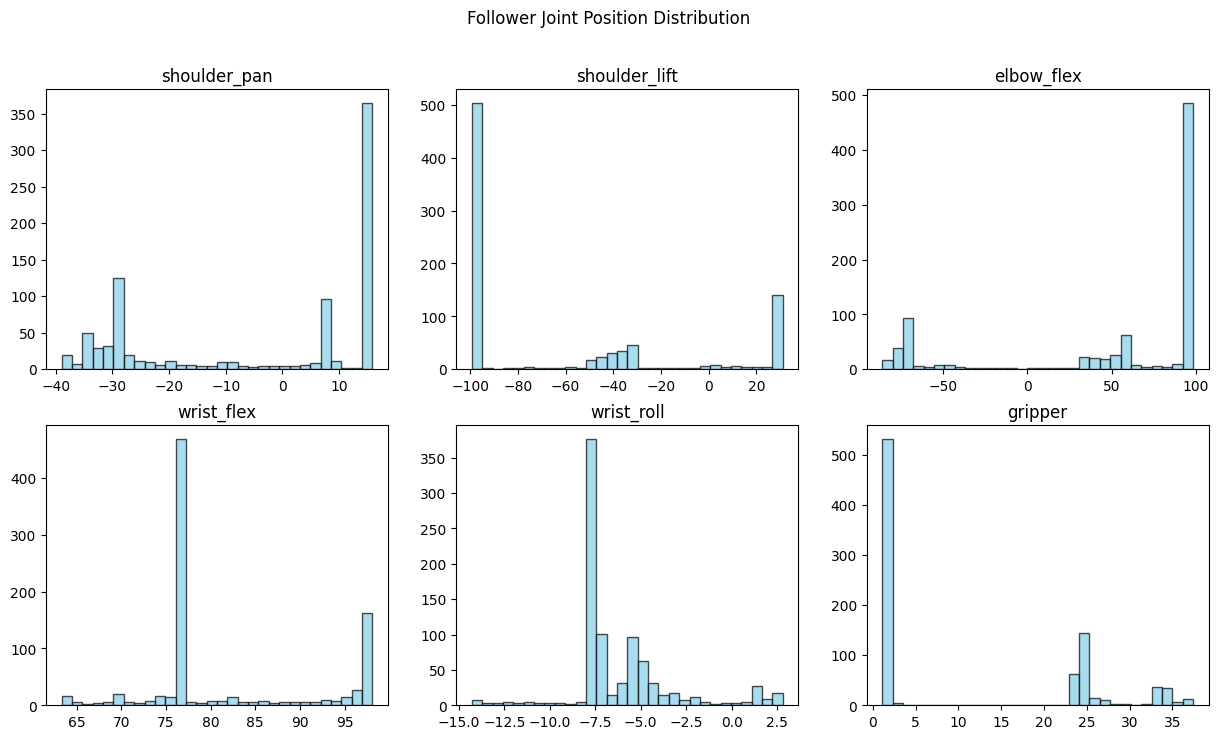

In [8]:
robot_joint_distribution("Follower", episode['observation.state'])

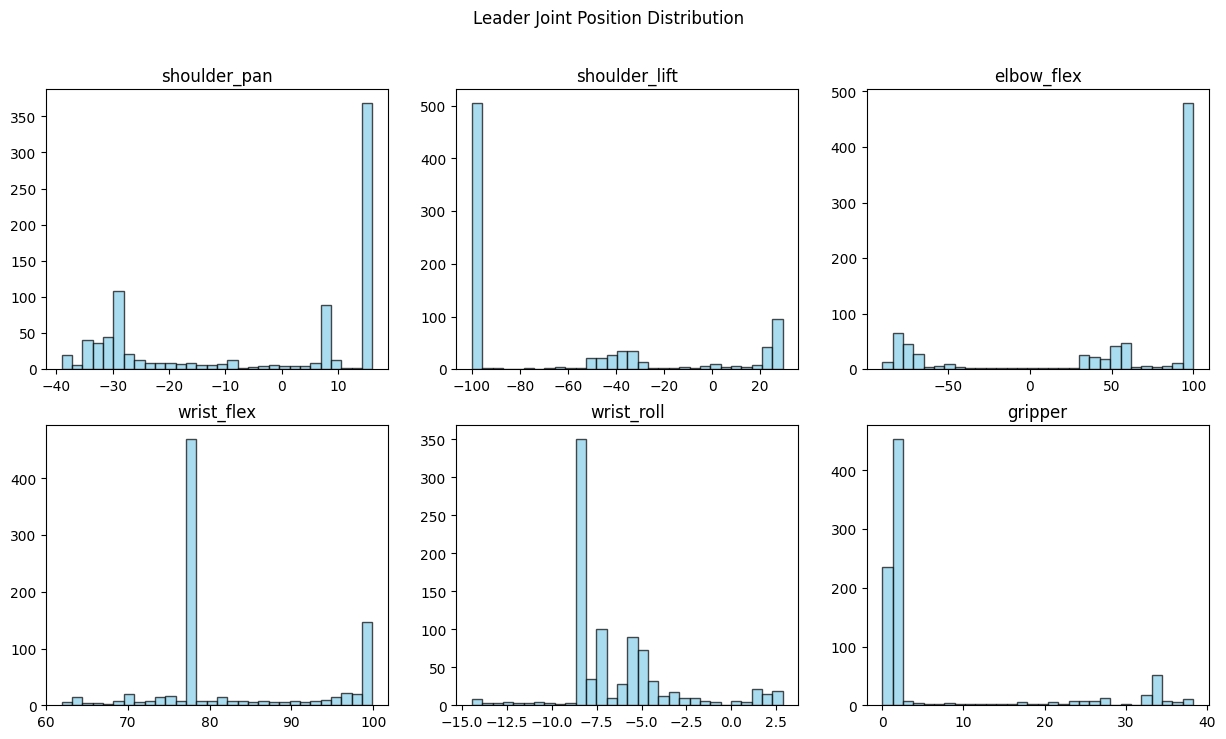

In [9]:
robot_joint_distribution("Leader", episode['action'])

## Gripper joint

The gripper joint connects the fixed jaw to the mobile jaw, allowing to open and close the gripper.

In [10]:
gripper_id = 5
frame_ids = episode['frame_index'].cpu()
follower_gripper = episode['action'][:,gripper_id].cpu()
leader_gripper = episode['observation.state'][:,gripper_id].cpu()

The Follower is behind on the leader by a few frames.

In [11]:
delay_frames = 4

truncated_leader = leader_gripper[delay_frames:]
truncated_frame_ids = frame_ids[:-delay_frames]

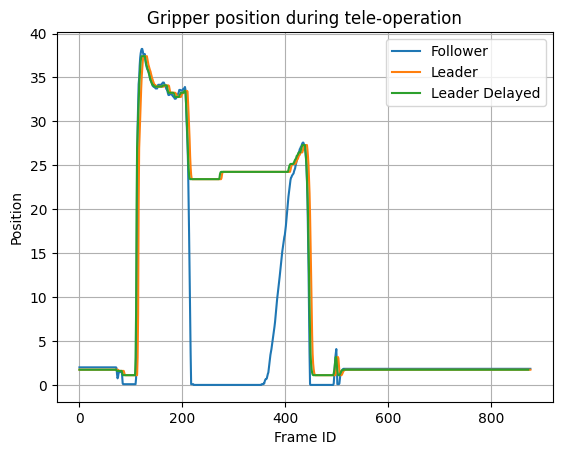

In [12]:
plt.plot(frame_ids, follower_gripper, label='Follower')
plt.plot(frame_ids, leader_gripper, label='Leader')
plt.plot(truncated_frame_ids, truncated_leader, label='Leader Delayed')
plt.xlabel('Frame ID')
plt.ylabel('Position')
plt.title('Gripper position during tele-operation')
plt.legend()
plt.grid(True)


### Step 1

The Leader is closed at the beginning in the rest position, corresponding to the `-17` gripper motor position. The Follower is also closed, the position capped at the `-8` position.

<center>
    <img src="../doc/LeaderArm.jpg" alt="Leader Arm" style="width:200px;"/>
</center>

### Step 2

The Leader opens the gripper.

### Step 3

The Leader closes the gripper.

### Step 4

When the Follower holds the ball, the grippers blocks at position `+24`, while the Leader closes all the way.

### Step 5

The Leader opens the gripper. Once the Leader reaches the Follower closed position and passes it to open it, the robotic arm releases the ball, placing it in the cup,

### Step 6

The Leader is closed again until the end, like in the beginning.

### Hold state

To identify the holding period, apply a threshold on the difference between the Leader & the Follower position.

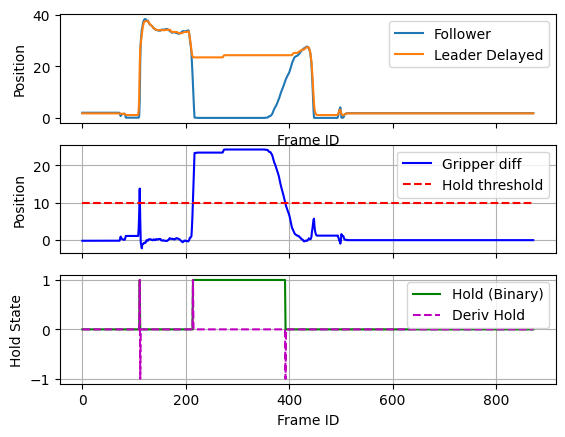

In [13]:

truncated_follower = follower_gripper[:-delay_frames]

gripper_diff = truncated_leader - truncated_follower
diff_threshold = 10
gripper_threshold = torch.full_like(gripper_diff, fill_value=diff_threshold)

above_threshold = torch.where(gripper_diff > diff_threshold, 1, 0)
above_threshold_derivative = torch.diff(above_threshold, prepend=above_threshold[0:1])

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)

ax1.plot(truncated_frame_ids, truncated_follower, label='Follower')
ax1.plot(truncated_frame_ids, truncated_leader, label='Leader Delayed')
ax1.set_xlabel('Frame ID')
ax1.set_ylabel('Position')
ax1.legend()
plt.grid(True)

# --- Top Plot: Gripper Diff and Threshold ---
ax2.plot(truncated_frame_ids, gripper_diff, 'b-', label='Gripper diff')
ax2.plot(truncated_frame_ids, gripper_threshold, 'r--', label='Hold threshold')
ax2.set_ylabel('Position')
ax2.legend()
ax2.grid(True)

# --- Bottom Plot: Hold and Derivative Signals ---
ax3.plot(truncated_frame_ids, above_threshold, 'g-', label='Hold (Binary)')
ax3.plot(truncated_frame_ids, above_threshold_derivative, 'm--', label='Deriv Hold')
ax3.set_xlabel('Frame ID')
ax3.set_ylabel('Hold State')
ax3.legend()
ax3.grid(True)


In [14]:
sustained_frames = ds_meta.fps # at least 1 sec of holding 

counter = torch.full_like(above_threshold, fill_value=0)

frame = len(above_threshold) - 1
counter[frame] = 1 if above_threshold[frame] == 1 else 0

hold_start_frames = []
hold_end_frames = []

for frame in range(frame-1, -1, -1):
    if above_threshold[frame] == 1:
        counter[frame] = counter[frame+1] + 1
    else:
        if counter[frame+1] >= sustained_frames:
            hold_start_frames.append(frame+1)
            hold_end_frame = frame + counter[frame+1]
            hold_end_frame = hold_end_frame.item()
            hold_end_frames.append(hold_end_frame)

        counter[frame] = 0

frame = 0
if counter[frame] >= sustained_frames:
    hold_start_frames.append(frame)
    hold_end_frame = frame + counter[frame] - 1
    hold_end_frame = hold_end_frame.item()
    hold_end_frames.append(hold_end_frame)

hold_start_frames, hold_end_frames

([214], [392])

The start and end frames of the holding period provide the pick and the place position respectively.

They identify the original positions of the ball and the cup.

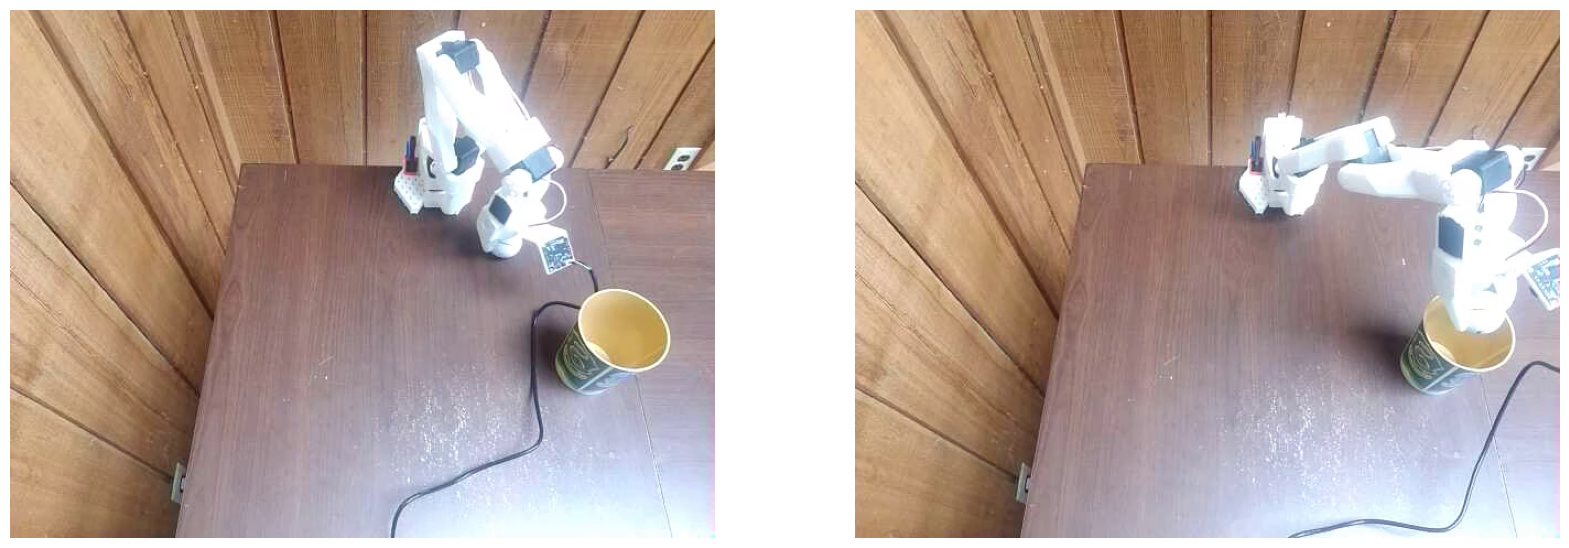

In [16]:
pick_frame_idx = hold_start_frames[0]
place_frame_idx = hold_end_frames[0]

camera = episode['observation.images.phone']

# Convert tensor to a 2D array of RGB pixels
# Channels x Width x Height -> Width x Height x Channels

pick_img = camera[pick_frame_idx]
pick_img = pick_img.data.numpy()
pick_img = pick_img.transpose(1, 2, 0)
pick_img = (pick_img * 255).astype("uint8")

place_img = camera[place_frame_idx]
place_img = place_img.data.numpy()
place_img = place_img.transpose(1, 2, 0)
place_img = (place_img * 255).astype("uint8")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(pick_img)
ax1.set_axis_off()
ax2.imshow(place_img)
ax2.set_axis_off()